In [3]:
import math
import statistics
import numpy as np
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from collections import defaultdict
from statistics import mean
%matplotlib inline

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss, make_scorer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import metrics
from yellowbrick.model_selection import FeatureImportances
from sklearn.tree import export_graphviz
import pydotplus

### RECAP: Summarize model selection and showing Random Forest as the best model.

In [4]:
df = pd.read_csv('cleaned_df.csv', low_memory = False)
df.drop(['Unnamed: 0'], axis = 1, inplace=True)

#select features, drop nulls (less than 1000 rows)
select_df = df[['soil_erosion','Slope','scifo','sciom','removal','tillage','rotation', 'soil_text','yield1']]
select_df = select_df.dropna()

#split the features from the target.
y = select_df['soil_erosion']
X = select_df[['Slope','scifo','sciom','removal','tillage','rotation', 'soil_text','yield1']]

#Set threshold and classify the target value into tolerated or not tolerated.
def func(y):
    if y <= 5: #Values for erosion that are above the NRCS tolerable soil loss limit of 1.12 kg m-2 (5 tons acre-1 ). 58(2):
        return 'tolerated'
    else:
        return 'not tolerated'
y = y.apply(func)

#use label encoder
le = LabelEncoder()
X = X.copy()
X.loc[:,'removal'] = le.fit_transform(X['removal'])
X.loc[:,'rotation'] = le.fit_transform(X['rotation'])
X.loc[:,'tillage'] = le.fit_transform(X['tillage'])
X.loc[:,'soil_text'] = le.fit_transform(X['soil_text'])
y = le.fit_transform(y)

#Split the dataset into train, validate, and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#Use stratified kfold to split data for cross validation - referenced from Kevin Chiv's notes
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
cv_results = defaultdict(list) #collect results from the model
X_train = np.array(X_train) #create indicies for kfold
y_train = np.array(y_train)

#Selected models to work with
models = {'Gradient Boost': GradientBoostingClassifier(), 
               'Bernoulli Naive Bayes': BernoulliNB(), 
               'KNN': KNeighborsClassifier(), 
               'Decision Tree':DecisionTreeClassifier(random_state=1234),
               'Random Forest':RandomForestClassifier(random_state=1234)}

#Iterate through the model dictionary to train and cross-validate on the data.
for model_name, model in models.items():
    for train_ind, val_ind in kf.split(X_train, y_train):
        X_tr, y_tr = X_train[train_ind], y_train[train_ind]
        X_val, y_val = X_train[val_ind], y_train[val_ind]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        precision = precision_score(y_val, y_pred)
        cv_results[model_name].append(precision)

#Average the cv results to determine the best model to use.
avg_cv = {}
for model_name, values in cv_results.items():
    print("Average CV result for {} is {}.".format(model_name, mean(values)))
    
#Print the classification report for each model    
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("***********************************************")
    print("The classification report for {}.".format(model_name))
    print(classification_report(y_test, y_pred))
    print("The confusion matrix for {}:".format(model_name))
    print(confusion_matrix(y_test, y_pred))
    

Average CV result for Gradient Boost is 0.9108360695838512.
Average CV result for Bernoulli Naive Bayes is 0.8073820543145646.
Average CV result for KNN is 0.9348892371229611.
Average CV result for Decision Tree is 0.9617492905140891.
Average CV result for Random Forest is 0.9624247650186318.
***********************************************
The classification report for Gradient Boost.
              precision    recall  f1-score   support

           0       0.88      0.80      0.84     16227
           1       0.91      0.95      0.93     35679

    accuracy                           0.90     51906
   macro avg       0.90      0.88      0.89     51906
weighted avg       0.90      0.90      0.90     51906

The confusion matrix for Gradient Boost:
[[12986  3241]
 [ 1719 33960]]
***********************************************
The classification report for Bernoulli Naive Bayes.
              precision    recall  f1-score   support

           0       0.63      0.55      0.59     16227
   

In [124]:
for model_name, values in cv_results.items():
    print("CV result standard deviation for {} is {}.".format(model_name, np.std(values)))

CV result standard deviation for Gradient Boost is 0.0008737085962560985.
CV result standard deviation for Bernoulli Naive Bayes is 0.0014142514001449864.
CV result standard deviation for KNN is 0.00111074131682589.
CV result standard deviation for Decision Tree is 0.0010543112339035088.
CV result standard deviation for Random Forest is 0.0006702281937405678.


In [125]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'not tolerated': 0, 'tolerated': 1}


0.9810569207502096
0.9526836974530882
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     16227
           1       0.96      0.97      0.97     35679

    accuracy                           0.95     51906
   macro avg       0.95      0.94      0.94     51906
weighted avg       0.95      0.95      0.95     51906

[(0.2309, 'sciom'), (0.1784, 'scifo'), (0.1552, 'Slope'), (0.1245, 'soil_text'), (0.1214, 'rotation'), (0.1112, 'yield1'), (0.0553, 'tillage'), (0.0231, 'removal')]


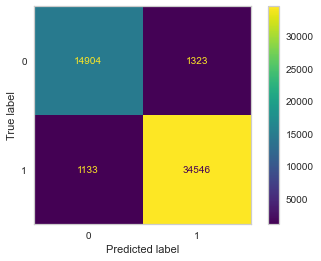

In [92]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)
print(rf.score(X_train_scaled,y_train))
print(rf.score(X_test_scaled,y_test))
prediction = rf.predict(X_test_scaled)
print(classification_report(y_test, prediction))
plot_confusion_matrix(rf, X_test_scaled, y_test)
plt.grid(b = None)
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))


<BarContainer object of 8 artists>

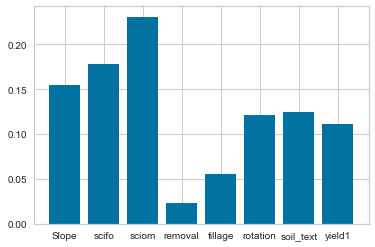

In [110]:
x_values = list(range(len(rf.feature_importances_)))
importances = list(rf.feature_importances_)
plt.bar(names, importances, linewidth = 12)

Try a smaller dataframe by dropping removal, soil texture, and yield. From the graph above, picked those that had high feature importance

0.9305585632407929
0.9021770514523301
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     16275
           1       0.92      0.93      0.93     35676

    accuracy                           0.90     51951
   macro avg       0.89      0.88      0.89     51951
weighted avg       0.90      0.90      0.90     51951

[0.18685123 0.29807759 0.35514577 0.1599254 ]
[(0.3551, 'sciom'), (0.2981, 'scifo'), (0.1869, 'Slope'), (0.1599, 'rotation')]


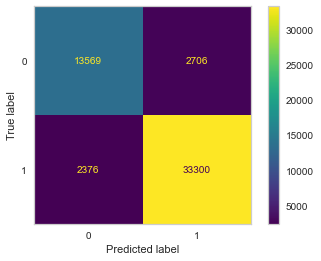

In [113]:
small_df = df[['soil_erosion', 'Slope','scifo','sciom','rotation']]
small_df = small_df.dropna()

#split the features from the target.
y2 = small_df['soil_erosion']
X2 = small_df[['Slope','scifo','sciom','rotation']]

#Set threshold and classify the target value into tolerated or not tolerated.
def func(y):
    if y <= 5: #Values for erosion that are above the NRCS tolerable soil loss limit of 1.12 kg m-2 (5 tons acre-1 ). 58(2):
        return 'tolerated'
    else:
        return 'not tolerated'
y2 = y2.apply(func)

le = LabelEncoder()
X2 = X2.copy()
X2.loc[:,'rotation'] = le.fit_transform(X2['rotation'])
#X2.loc[:,'soil_text'] = le.fit_transform(X2['soil_text'])
y2 = le.fit_transform(y2)

#Split the dataset into train, validate, and test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state = 42)

rf2 = RandomForestClassifier()
rf2.fit(X2_train, y2_train)
print(rf2.score(X2_train,y2_train))
print(rf2.score(X2_test,y2_test))
prediction = rf2.predict(X2_test)
print(classification_report(y2_test, prediction))
plot_confusion_matrix(rf2, X2_test, y2_test)
plt.grid(b = None)
print(rf2.feature_importances_)
print(sorted(zip(map(lambda x: round(x, 4), rf2.feature_importances_), X2.columns), 
             reverse=True))

Accuracy decreased around 5%. Therefore, even if farmers had limited amount of information they could still use the model and will be able to predict with 90% accuracy.

0.9809846740711485
0.9524717759025931
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     16227
           1       0.96      0.97      0.97     35679

    accuracy                           0.95     51906
   macro avg       0.95      0.94      0.94     51906
weighted avg       0.95      0.95      0.95     51906

[0.14837786 0.24795595 0.24769208 0.12313415 0.12652408 0.10631587]
[(0.248, 'scifo'), (0.2477, 'sciom'), (0.1484, 'Slope'), (0.1265, 'soil_text'), (0.1231, 'rotation'), (0.1063, 'yield1')]


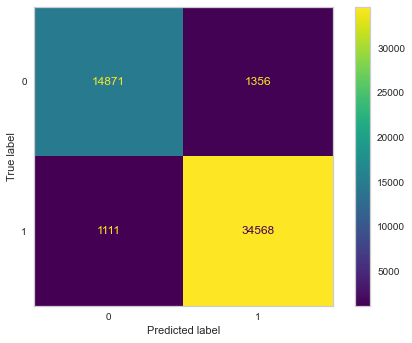

In [5]:
small_df = df[['soil_erosion', 'Slope','scifo','sciom','rotation', 'soil_text','yield1']]
small_df = small_df.dropna()

#split the features from the target.
y3 = small_df['soil_erosion']
X3 = small_df[['Slope','scifo','sciom','rotation', 'soil_text','yield1']]

#Set threshold and classify the target value into tolerated or not tolerated.
def func(y):
    if y <= 5: #Values for erosion that are above the NRCS tolerable soil loss limit of 1.12 kg m-2 (5 tons acre-1 ). 58(2):
        return 'tolerated'
    else:
        return 'not tolerated'
y3 = y3.apply(func)

le = LabelEncoder()
X3 = X3.copy()
X3.loc[:,'rotation'] = le.fit_transform(X3['rotation'])
X3.loc[:,'soil_text'] = le.fit_transform(X3['soil_text'])
y3 = le.fit_transform(y3)

#Split the dataset into train, validate, and test
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state = 42)

rf3 = RandomForestClassifier()
rf3.fit(X3_train, y3_train)
print(rf3.score(X3_train,y3_train))
print(rf3.score(X3_test,y3_test))
prediction = rf3.predict(X3_test)
print(classification_report(y3_test, prediction))
plot_confusion_matrix(rf3, X3_test, y3_test)
plt.grid(b = None)
print(rf3.feature_importances_)
print(sorted(zip(map(lambda x: round(x, 4), rf3.feature_importances_), X3.columns), 
             reverse=True))

In this model, the features tillage and removal were taken out from the model and still predicted with 95% accuracy. Use slope, scifo, sciom, soil texture, rotation, and yield (in order of importance) for the Streamlit app. The goal is to provide a simple model with few features but great prediction accuracy so that farmers can use the model.

In [135]:
prediction

array([1, 1, 0, ..., 1, 1, 1])

Make a dataframe with SSURGO data in order to map the tolerated and not tolerated region in GIS. The mukey is the only location identifier. It may be possible to pull coordinates from GIS and export it into a csv to map in Python.

In [153]:
ssurgo_df = df[['areasymbol', 'CoFIPS', 'mukey', 'musym', 'muname', 'muacres','soil_erosion', 'Slope','scifo','sciom','rotation', 'soil_text','yield1']]
ssurgo_df = ssurgo_df.dropna()
def func(y):
    if y <= 5: #Values for erosion that are above the NRCS tolerable soil loss limit of 1.12 kg m-2 (5 tons acre-1 ). 58(2):
        return 'tolerated'
    else:
        return 'not tolerated'
ssurgo_df['actual'] = ssurgo_df['soil_erosion'].apply(func)

In [159]:
prediction = rf3.predict(X3)
predict = []
for pred in prediction:
    if pred == 1:
        predict.append('tolerated')
    else:
        predict.append('not tolerated')
ssurgo_df['prediction'] = predict

In [160]:
len(predict)

259528

In [161]:
ssurgo_df.shape

(259528, 15)

In [163]:
ssurgo_df.to_csv('ssurgo_df.csv')

## GridSearchCV

Model parameter tuning to determine the best parameters for Random Forest

In [115]:
param_grid = {'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}
# Create a based model
rf_cv = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_cv, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X3_train, y3_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 67.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 135.1min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 186.4min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [119]:
best_grid = grid_search.best_estimator_
print(best_grid)

RandomForestClassifier(max_depth=90, max_features=3, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=300)


0.9688183333172785
0.9515277617231148
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     16227
           1       0.96      0.97      0.96     35679

    accuracy                           0.95     51906
   macro avg       0.95      0.94      0.94     51906
weighted avg       0.95      0.95      0.95     51906

[0.14338561 0.26677505 0.24349584 0.13139976 0.13197667 0.08296707]
[(0.2668, 'scifo'), (0.2435, 'sciom'), (0.1434, 'Slope'), (0.132, 'soil_text'), (0.1314, 'rotation'), (0.083, 'yield1')]


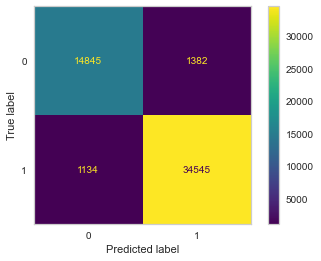

In [121]:
best_rf = RandomForestClassifier(max_depth=90, max_features=3, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=300)
best_rf.fit(X3_train, y3_train)
print(best_rf.score(X3_train,y3_train))
print(best_rf.score(X3_test,y3_test))
prediction = best_rf.predict(X3_test)
print(classification_report(y3_test, prediction))
plot_confusion_matrix(best_rf, X3_test, y3_test)
plt.grid(b = None)
print(best_rf.feature_importances_)
print(sorted(zip(map(lambda x: round(x, 4), best_rf.feature_importances_), X3.columns), 
             reverse=True))



#### Just for fun - Visualize a Decision Tree 

0.8526052991091185
0.8531324559378126
              precision    recall  f1-score   support

           0       0.80      0.70      0.75     16157
           1       0.87      0.92      0.90     35815

    accuracy                           0.85     51972
   macro avg       0.84      0.81      0.82     51972
weighted avg       0.85      0.85      0.85     51972



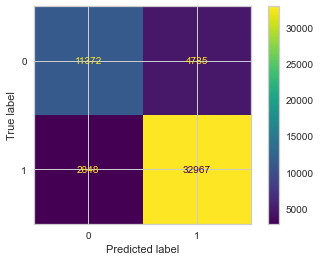

In [68]:
small_df = select_df = df[['soil_erosion','removal','tillage','rotation','soil_text']]
small_df = small_df.dropna()

#split the features from the target.
y1 = small_df['soil_erosion']
X1 = small_df[['removal','tillage','rotation','soil_text']]

#Set threshold and classify the target value into tolerated or not tolerated.
def func(y):
    if y <= 5: #Values for erosion that are above the NRCS tolerable soil loss limit of 1.12 kg m-2 (5 tons acre-1 ). 58(2):
        return 'tolerated'
    else:
        return 'not tolerated'
y1 = y1.apply(func)

le = LabelEncoder()
X1 = X1.copy()
X1.loc[:,'removal'] = le.fit_transform(X1['removal'])
X1.loc[:,'rotation'] = le.fit_transform(X1['rotation'])
X1.loc[:,'tillage'] = le.fit_transform(X1['tillage'])
X1.loc[:,'soil_text'] = le.fit_transform(X1['soil_text'])
y1 = le.fit_transform(y1)

#Split the dataset into train, validate, and test
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state = 42)

dtc = DecisionTreeClassifier(max_depth = 10)
dtc.fit(X1_train, y1_train)

print(dtc.score(X1_train,y1_train))
print(dtc.score(X1_test,y1_test))
dtc_prediction = dtc.predict(X1_test)
print(classification_report(y1_test, dtc_prediction))
plot_confusion_matrix(dtc, X1_test, y1_test)

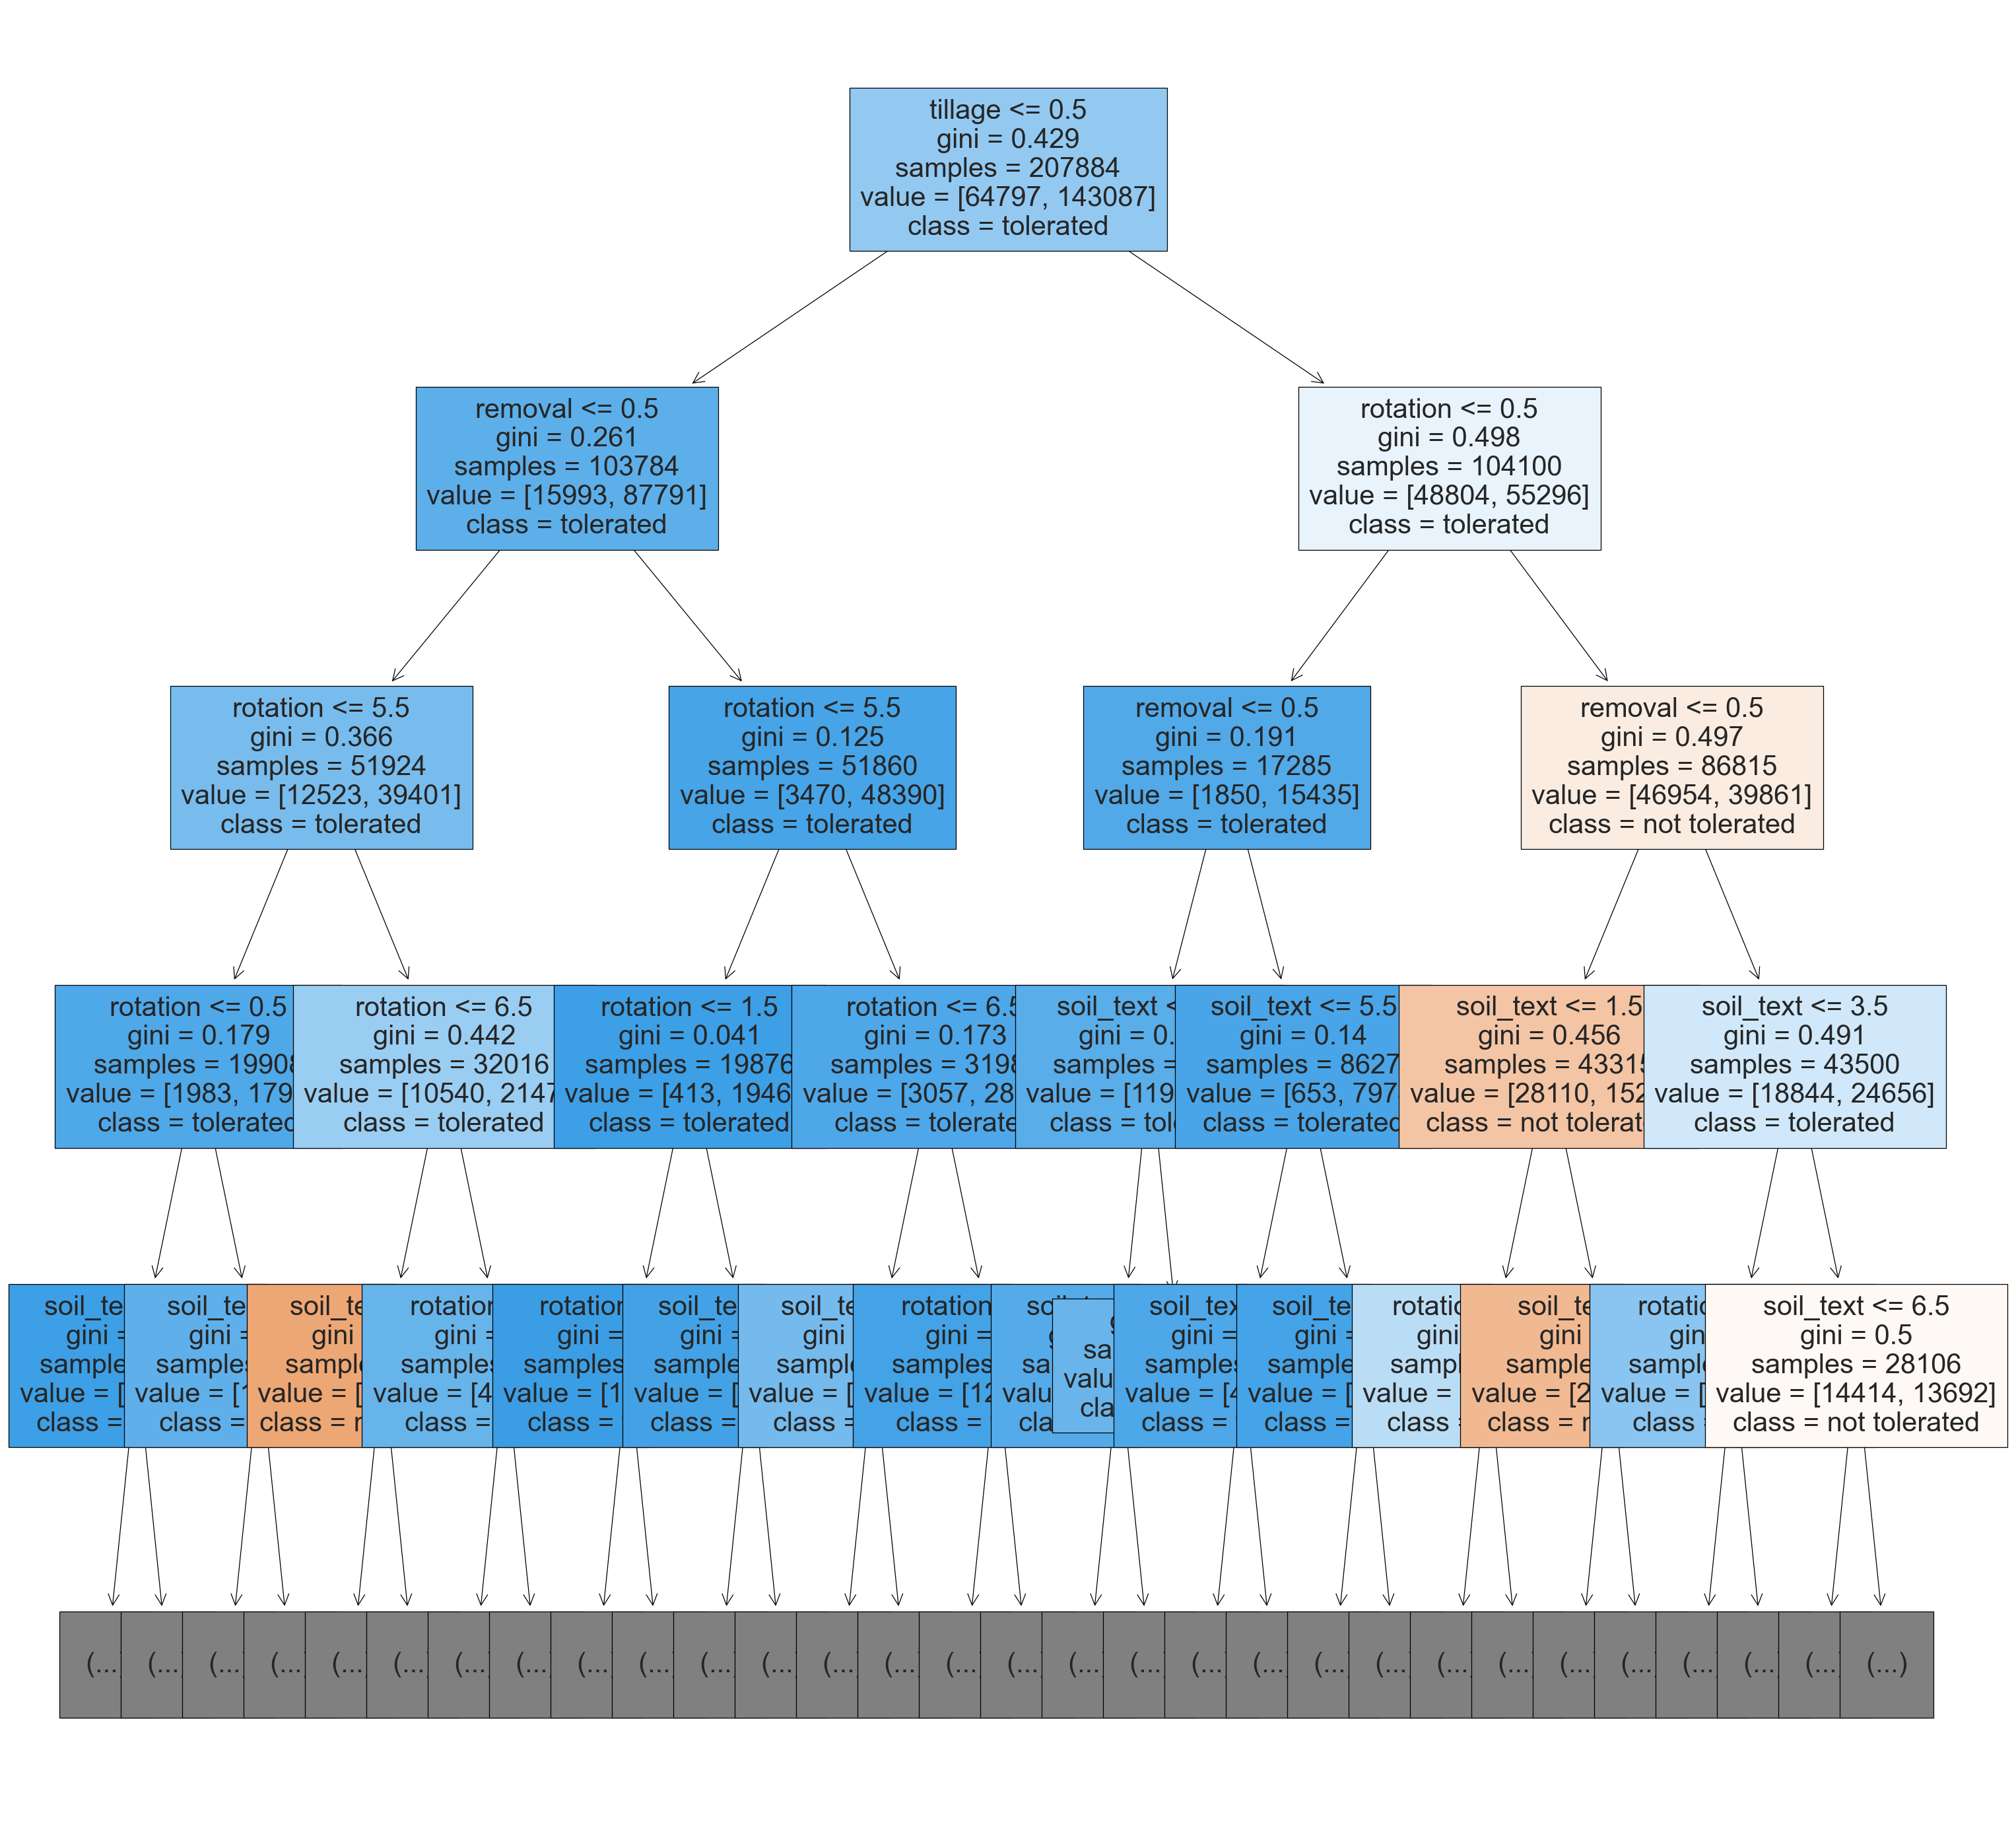

In [70]:
from sklearn import tree


fn = ['removal','tillage','rotation','soil_text']
cn = ['not tolerated', 'tolerated']
fig, ax = plt.subplots(figsize=(12, 12), dpi=300)
tree.plot_tree(dtc.fit(X1_train, y1_train),feature_names = fn, class_names = cn, filled = True, max_depth=4, fontsize=10)
plt.show()
fig.savefig('dtctree3.png')